In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'


In [49]:
import os
from datetime import datetime
from PIL import Image
import tensorflow as tf
import time
from tensorflow.python.keras.callbacks import TensorBoard
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
import gc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
import cv2
import matplotlib.cm as cm
from IPython.display import Image, display
import csv
from PIL.Image import fromarray
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from importlib import reload
import csv
import pandas as pd
from image_crop import crop_image
from sklearn.utils import shuffle

In [50]:
def fun_labels(number):
    if number==0:
        return 'NOT_EXPLORED'
    if number ==1:
        return 'EXPLORED'

In [51]:
df_train = pd.read_csv('dataframes/df_train.csv')
# df_val = pd.read_csv('df_val_regr.csv')
df_test = pd.read_csv('dataframes/df_test.csv')
df_train['class'] = df_train['class'].apply(fun_labels)
# df_val['class'] = df_val['class'].apply(fun_labels)
df_test['class'] = df_test['class'].apply(fun_labels)


df_train=df_train.drop(['class'],axis=1)
# df_val=df_val.drop(['class'],axis=1)
df_test=df_test.drop(['class'],axis=1)

#df_train = shuffle(df_train)
#df_val = shuffle(df_val)
#df_test = shuffle(df_test)
#def fun(path):
#    return path.replace('TOSHIBA EXT','TOSHIBA\ EXT')

#df['img_path'] = df['img_path'].apply(fun)

SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = os.getcwd()

In [52]:
print(df_train['img_path'][0])
df_train.head()

/home/aislab/Documents/StakanovThesis/robot-aware-exploration/Datasets/Labelled_Data/KTH+MIT/train/NOT_EXPLORED/12-1@run1@0Map.png


,img_path,diff_perc
0,/home/aislab/Documents/StakanovThesis/robot-aw...,104.394730
1,/home/aislab/Documents/StakanovThesis/robot-aw...,102.093084
2,/home/aislab/Documents/StakanovThesis/robot-aw...,90.250886
3,/home/aislab/Documents/StakanovThesis/robot-aw...,79.326988
4,/home/aislab/Documents/StakanovThesis/robot-aw...,71.806965


In [53]:
# print(df_val['img_path'][0])
# df_val.head()

In [54]:
print(df_test['img_path'][0])
# df_val.head()

/home/aislab/Documents/StakanovThesis/robot-aware-exploration/Datasets/Labelled_Data/KTH+MIT/test/NOT_EXPLORED/36-5@run1@0Map.png


In [55]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11313441151246781245
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5183593536
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18045497239823674601
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


2024-09-17 18:19:44.237618: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-09-17 18:19:44.237794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-17 18:19:44.237918: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7085GHz coreCount: 10 deviceMemorySize: 5.92GiB deviceMemoryBandwidth: 178.99GiB/s
2024-09-17 18:19:44.237947: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-09-17 18:19:44.237980: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-09-17 18:19:44.237995: I tensorflow/stream_executor/pla

In [56]:

def orthogonal_rot(image):
    img=np.rot90(image, np.random.choice([-1, 0, 1]))
    img=tf.keras.applications.efficientnet.preprocess_input(img)
    return img

apply_data_augmentation = True

# Create training ImageDataGenerator object
if apply_data_augmentation:
    train_data_gen = ImageDataGenerator(
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        zoom_range=[1.0,1.3],
                                        #fill_mode='nearest',
                                        #cval=0,
                                        preprocessing_function=orthogonal_rot,
                                        #rescale=1./255,
                                        )

valid_data_gen = ImageDataGenerator(#horizontal_flip=True,
                                        #vertical_flip=True,
                                        #zoom_range=[1.0,1.3],
                                        #fill_mode='nearest',
                                        #cval=0,
                                        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                                        #rescale=1./255,
                                        #validation_split=0.2
)


test_data_gen = ImageDataGenerator(#horizontal_flip=True,
                                        #vertical_flip=True,
                                        #zoom_range=[1.0,1.3],
                                        #fill_mode='nearest',
                                        #cval=0,
                                        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                                        #rescale=1./255,
                                        #validation_split=0.2
)

In [57]:
# Create generators to read images from dataset directory
# -------------------------------------------------------
#dataset_dir = os.path.join(cwd,'labelled_datasets/dataset_1/')

# Batch size
bs = 8

# img shape
img_h = 500
img_w = 500

num_classes=2

# Training
#training_dir = os.path.join(dataset_dir, 'train')
train_gen = train_data_gen.flow_from_dataframe(dataframe=df_train,
                                                directory=None,
                                                x_col='img_path',
                                                y_col='diff_perc',
                                               batch_size=bs,
                                               target_size=(img_h,img_w),
                                               color_mode='rgb',
                                               class_mode='raw',
                                               shuffle=True,
                                               seed=SEED
                                               )  # targets are directly converted into one-hot vectors

# Validation
#validation_dir = os.path.join(dataset_dir, 'valid')
# valid_gen = valid_data_gen.flow_from_dataframe(dataframe=df_val,
#                                                 directory=None,
#                                                 x_col='img_path',
#                                                 y_col='diff_perc',
#                                                batch_size=bs,
#                                                target_size=(img_h,img_w),
#                                                color_mode='rgb',
#                                                class_mode='raw',
#                                                shuffle=True,
#                                                seed=SEED
#                                                )

# Test
#test_dir = os.path.join(dataset_dir, 'test')

test_gen = test_data_gen.flow_from_dataframe(dataframe=df_test,
                                                directory=None,
                                                x_col='img_path',
                                                y_col='diff_perc',
                                               batch_size=bs,
                                               target_size=(img_h,img_w),
                                               color_mode='rgb',
                                               class_mode='raw',
                                               shuffle=False,
                                               seed=SEED
                                               )



Found 3771 validated image filenames.
Found 3458 validated image filenames.


In [58]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))



Num GPUs Available:  1


In [59]:
enet = tf.keras.applications.EfficientNetB1(input_shape=(img_h,img_w,3),include_top=False,weights='imagenet')

finetuning=True

if finetuning:
    freeze_until = 200 # layer from which fine-tuning starts
    
    for layer in enet.layers[:freeze_until]:
        layer.trainable = False
else:
    enet.trainable = False


model=tf.keras.Sequential()
model.add(enet)
model.add(Conv2D(1280,1,padding="same",activation='relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(units=1, activation='relu'))


In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 16, 16, 1280)      6575239   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 1280)      1639680   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 8,216,200
Trainable params: 7,440,885
Non-trainable params: 775,315
_________________________________________________________________


In [61]:
# #Optimization parameters

# #Learning rate
# lr = 1e-4
# optimizer = tf.keras.optimizers.Adam(lr=lr)

# #Compile model
# model.compile(optimizer=optimizer, loss='mean_squared_error')

In [62]:
# callbacks = []

# early_stop = True
# tensorboard = True
# if early_stop:
#     es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12,restore_best_weights=True)
#     callbacks.append(es_callback)
# if tensorboard:
#     tensorboard = TensorBoard(log_dir=os.path.join(cwd,'tensorboard_logs_regression'))
#     callbacks.append(tensorboard)

In [63]:
# model.fit_generator(train_gen,
# steps_per_epoch=len(train_gen)//bs,
# epochs=24,
# verbose=1,
# validation_data=valid_gen,
# validation_steps=len(valid_gen)//bs)

In [64]:
# %load_ext tensorboard
# %tensorboard --logdir tensorboard_logs

In [65]:
# model_save_path = os.path.join(cwd,'checkpoint_weights_regression')
# if not os.path.exists(model_save_path):
#     os.makedirs(model_save_path)
# model.save_weights(os.path.join(model_save_path,'weights_1.h5'))

In [66]:
model_load_path = os.path.join(cwd,'checkpoint_weights', 'weights_regression','weights_1.h5')
model.load_weights(model_load_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(8, 500, 500, 3)


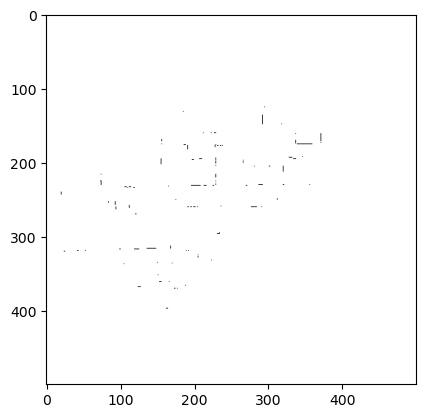

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


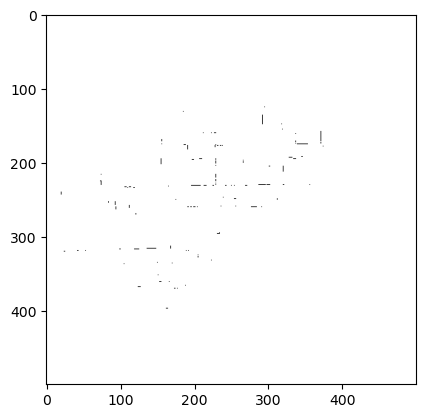

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


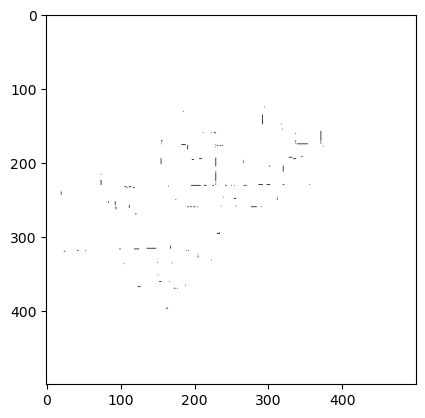

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


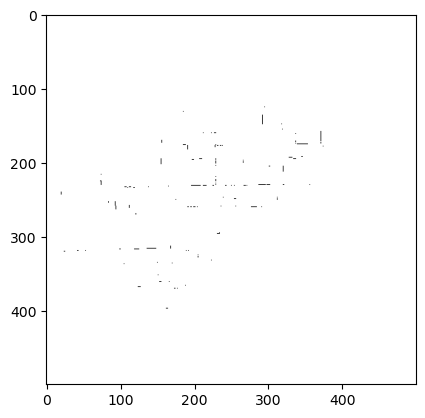

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


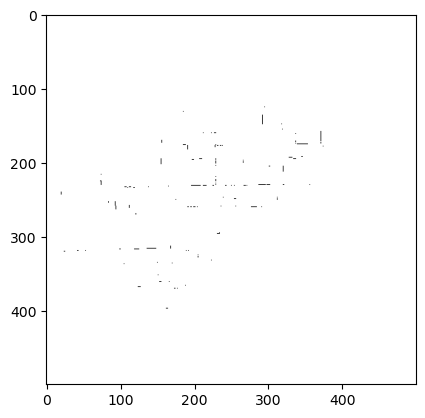

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


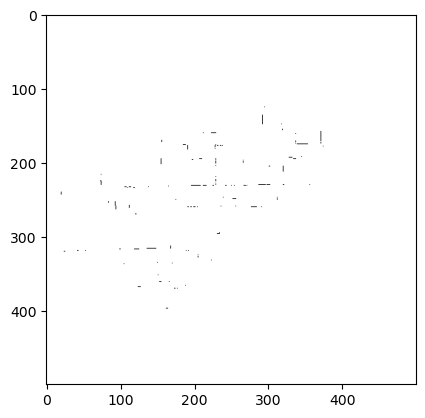

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


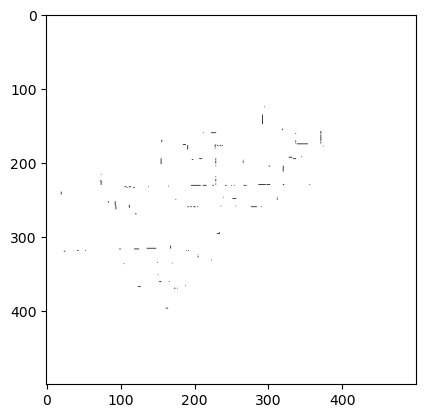

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


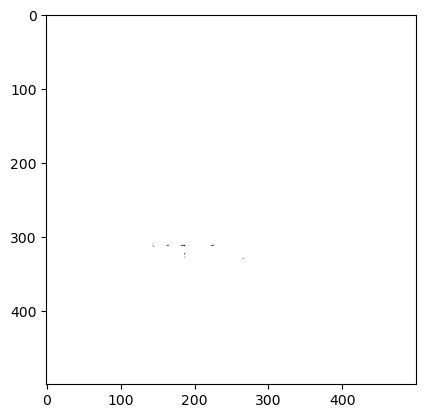

In [67]:
print(test_gen.next()[0].shape)
z= test_gen.next()
for i in range(0,8):
    plt.imshow(z[0][i])
    plt.show()


In [68]:
pred=model.predict(test_gen,verbose=1)


433/433 [==============================] - 86s 198ms/step


In [69]:
print(pred)
print(len(pred))
print(len(df_test))

[[71.25623  ]
 [43.036053 ]
 [36.987453 ]
 ...
 [10.7954235]
 [ 0.       ]
 [ 0.       ]]
3458
3458


In [70]:
df_test['prediction'] = pred
df_test['abs_error'] = df_test['prediction']-df_test['diff_perc']
df_test['abs_error'] = df_test['abs_error'].apply(abs)
df_test['mean_abs_error'] = df_test['abs_error'].mean()
print(df_test)


                                               img_path   diff_perc  \
0     /home/aislab/Documents/StakanovThesis/robot-aw...  106.736574   
1     /home/aislab/Documents/StakanovThesis/robot-aw...   88.505788   
2     /home/aislab/Documents/StakanovThesis/robot-aw...   64.299957   
3     /home/aislab/Documents/StakanovThesis/robot-aw...   49.537566   
4     /home/aislab/Documents/StakanovThesis/robot-aw...   39.943350   
...                                                 ...         ...   
3453  /home/aislab/Documents/StakanovThesis/robot-aw...   33.177183   
3454  /home/aislab/Documents/StakanovThesis/robot-aw...   25.810911   
3455  /home/aislab/Documents/StakanovThesis/robot-aw...    9.809324   
3456  /home/aislab/Documents/StakanovThesis/robot-aw...    0.197108   
3457  /home/aislab/Documents/StakanovThesis/robot-aw...    0.061116   

      prediction  abs_error  mean_abs_error  
0      71.256233  35.480340       11.374693  
1      43.036053  45.469735       11.374693  
2      36

In [71]:
df_test.to_csv('Results/regression_results.csv')